<center>

---
---

# Inference with a Differentiable Pipeline

</center>

---
---

This notebook shows a series of advanced examples made possible by pairing `candl` with a differentiable theory code (here CosmoPower-JAX).
In this tutorial, we will cover the use of gradient based minimisers and samplers (here NUTS sampling).
We interface the likelihood with the Optax and BlackJAX libraries.
We use the ACT DR4 CMB-only TTTEEE data set throughout this example.

Content:
* Likelihood initialisation and data handling
* Running a simple Newton-Raphson minmiser
* Running an ADAM minimiser
* NUTS sampling

*Note*: This tutorial uses some optional packages.
Make sure you have JAX (0.4.24), Optax (0.2.2), BlackJAX (1.1.1), getdist, CosmoPower-JAX, and tqdm installed in order to run the whole notebook.
You also need to have some emulator models for CosmoPower-JAX; we recommend the SPT high-accuracy models available here: https://github.com/alessiospuriomancini/cosmopower/tree/main/cosmopower/trained_models/SPT_high_accuracy.



In [1]:
# Necessary imports and setup
%matplotlib widget

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import candl
import candl.interface
import candl.tools
import candl.plots
import candl.data

candl.plots.set_plot_style()# Set the plot style (font sizes, tick widths, ...)

import optax
import blackjax
from datetime import date

from tqdm.notebook import tqdm

from copy import deepcopy

from getdist import MCSamples

# Likelihood Initialisation and Data Handling

Below we initialise the likelihood by pointing it to the data set .yaml file.
For released data sets, short cuts can be accessed via `candl.data.<data set name>`.
The .yaml file contains all the necessary info, e.g. the spectra we are fitting, the band power file, the covariance file, informations on the priors, etc.
Once the likelihood is initialised, we have easy access to all relevant aspects of the data and can e.g. plot the band powers with ease.

In [2]:
# Initialise the ACT DR4 CMB-only TTTEEE likelihood
candl_like = candl.Like(candl.data.ACT_DR4_TTTEEE)


Successfully initialised candl likelihood 'ACT DR4 TT/TE/EE (Choi et al. 2020, Aiola et al. 2020)' (type: <class 'candl.likelihood.Like'>).
Data loaded from '/opt/homebrew/Cellar/python@3.10/3.10.14/envs/jax_env/lib/python3.10/site-packages/candl/data/ACT_DR4_CMB_only_v0/'.
Functional likelihood form: gaussian
--------------------------------------------------------------------------------
It will analyse the following spectra:

TT dxd       (40 bins, bin centres spanning ell = 600.3 - 4123.0)
TE dxd       (45 bins, bin centres spanning ell = 350.5 - 4123.0)
EE dxd       (45 bins, bin centres spanning ell = 350.3 - 4122.9)
TT wxw       (40 bins, bin centres spanning ell = 600.4 - 4122.3)
TE wxw       (45 bins, bin centres spanning ell = 350.5 - 4122.4)
EE wxw       (45 bins, bin centres spanning ell = 350.4 - 4122.4)
--------------------------------------------------------------------------------
A data model consisting of 1 transformations has been initialised.
The following transform

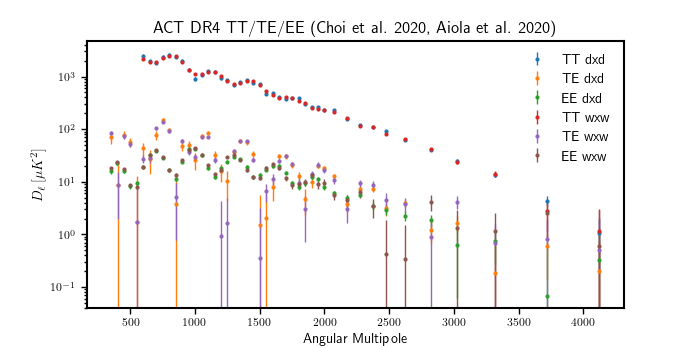

In [3]:
# Plot the band powers!
# This is a simple plotting stript that accesses candl_like.data_bandpowers
# 'd' and 'w' denote deep and wide fields respectively
plt.close()
candl.plots.plot_band_powers(candl_like, colour_by_spec_type=False)
plt.show()

# Theory Code Interface

Below we initialise our CosmoPower-JAX models and bundle them with the likelihood to create a function that moves from a dictionary of parameter values directly to the log likelihood value.

In [4]:
# Grab a theory calculator and initialise it
# Here, we use our differentiable, high-precision CosmoPower models
# These take care of the step of moving from cosmological parameters to theory Cls
cp_emulator_filenames = {"TT": "cmb_spt_TT_NN.npz",
                         "TE": "cmb_spt_TE_PCAplusNN.npz",
                         "EE": "cmb_spt_EE_NN.npz"}
pars_to_theory_specs = candl.interface.get_CosmoPowerJAX_pars_to_theory_specs_func(cp_emulator_filenames)

# Define fiducial parameters - cosmological ones by hand
fid_pars = {'H0': 67.37,
            'ombh2': 0.02233,
            'omch2': 0.1198,
            'logA': 3.043,
            'ns': 0.9652,
            'tau': 0.054,
            'yp': 1.0}

# Here, we grab a function that moves from parameters to logl all in one step.
# This is a light wrapper that combines our theory calculator (CosmoPower) and our likelihood.
# There's a bit of glue in-between, which crops the spectra to the right ell range.
# We also grab the derivative and the Hessian
like = jax.jit(candl.tools.get_params_to_logl_func(candl_like, pars_to_theory_specs))
like_deriv = jax.jit(jax.jacrev(like))
like_hessian = jax.jit(jax.hessian(like))


Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa).
Falling back to the dictionary, if case this also fails or does not output the right shape make sure you ran the `convert_tf214.py` script, and that a `.npz` file exists among the trained models, and that you ran `pip install .`. Also make sure that you are asking for the right probe between `custom_log` and `custom_pca`.
Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa).
Falling back to the dictionary, if case this also fails or does not output the right shape make sure you ran the `convert_tf214.py` script, and that a `.npz` file exists among the trained models, and that you ran `pip install .`. Also make sure that you are asking for the r

# Gradient-Based Minimisers

We run two gradient-based minimisers below.
First, a Newton-Raphson minimiser.
Note: this is a simple implementation of the algorithm, neither stress-tested nor fail-safe.
This algorithm is neat, as it requires the evaluation of the Hessian, which we can keep hold of and use to obtain the parameter covariance matrix.
We assess the convergence of the minimiser before moving on.
Second, we interface the likelihood with Optax and run an ADAM minimiser.
The first couple of steps for either minimiser are relatively slow due to the use of jit(), though subsequent evaluations are much faster.



## Newton-Raphson Minimiser

In [5]:
# We want to minimise all parameters - cosmological ones and nuisance parameters
pars_for_min = ["H0", "ombh2", "omch2", "ns", "logA", "tau"] + candl_like.required_nuisance_parameters

# Set the fiducial starting point
starting_pars = deepcopy(fid_pars)

# Step through minimiser
newton_points, newton_par_covs = candl.tools.newton_raphson_minimiser(like_deriv = like_deriv,# Derivative function
                                                                 like_hess = like_hessian,# Hessian function
                                                                 starting_pars = starting_pars,# Start point
                                                                 pars_for_min = pars_for_min,# Which parameters to minimise
                                                                 N_newton = 20,# How many steps to take
                                                                 show_progress = True)# Show loading bars

  0%|          | 0/20 [00:00<?, ?it/s]

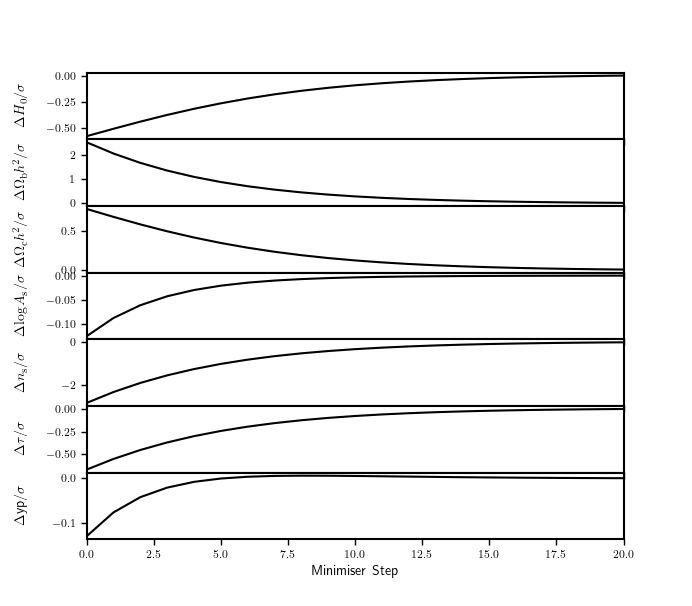

In [6]:
# Check the convergence of the minimiser by plotting the evolution of the parameter values.
# This plots shows the parameter steps relative to the final point and in units of the covariance matrix.
plt.close()
candl.plots.plot_minimiser_convergence(newton_points,
                                       par_cov=newton_par_covs[-1],
                                       par_cov_order=pars_for_min,
                                       relative=True)
plt.show()

## ADAM Minimiser (Optax Interface)

We need to do a little bit of prep before feeding the likelihood into Optax.
Optax prefers working with N(0, 1) distributed values, so we use Planck 18 (our fiducial parameter values) as a reference point and the parameter covariance from the Newton-Raphson minimiser as the scale. We can alternatively obtain the scale by using `candl.tools.get_fisher_matrix` instead.
Once ADAM is done, we compare the trajectories of the two gradient-based minimisers

In [7]:
# Grab expected size of parameter errors based on Fisher matrix
par_scales = {}
for i, p in enumerate(pars_for_min):
    par_scales[p] = jnp.sqrt(newton_par_covs[-1][i,i])

# Helper functions to move from regular units to N(0,1)
def transform_to_zero_mean_unit_var(par_dict):
    new_par_dict = {}
    for p in par_dict:
        if p in fid_pars and p in par_scales:
            new_par_dict[p] = jnp.array((par_dict[p] - fid_pars[p])/par_scales[p], float)
    return new_par_dict

def transform_from_zero_mean_unit_var(par_dict):
    new_par_dict = {}
    for p in par_dict:
        if p in fid_pars and p in par_scales:
            new_par_dict[p] = jnp.array(fid_pars[p] + par_dict[p]*par_scales[p], float)
    return new_par_dict

# Here, we grab a function that moves from normed parameters to logl all in one step.
like_normed = jax.jit(lambda p: -1.0*like(transform_from_zero_mean_unit_var(p)))# ADAM uses a different sign convention (logl to be positive)
like_normed_deriv = jax.jit(jax.jacrev(like_normed))

In [8]:
# Initialise the ADAM minimiser and starting point
adam_optimiser = optax.adam(learning_rate = 0.75)
starting_pars = transform_to_zero_mean_unit_var(deepcopy(fid_pars))
opt_state = adam_optimiser.init(starting_pars)

# Keep hold of all points
adam_logl_vals = []
adam_eval_points = [transform_from_zero_mean_unit_var(starting_pars)]

# Minimise!
N_adam = 100# number of steps
pbar = tqdm(total=N_adam)# Start progress bar
this_pars = deepcopy(starting_pars)
for i_adam in range(N_adam):

    # Get like value and gradient
    this_logl = like_normed(this_pars)
    this_grad = like_normed_deriv(this_pars)

    # Pass information to optax to get next step of minimiser
    updates, opt_state = adam_optimiser.update(this_grad,
                                               opt_state,
                                               this_pars)
    
    # Apply updates to the parameters
    this_pars = optax.apply_updates(this_pars,
                                    updates)

    # Keep hold of scaled pars (in right units), logl, and increment progress bar
    adam_eval_points.append(transform_from_zero_mean_unit_var(this_pars))
    adam_logl_vals.append(this_logl)
    pbar.update(1)

adam_logl_vals.append(like_normed(this_pars))# grab final logl value
pbar.close()# close progress bar


  0%|          | 0/100 [00:00<?, ?it/s]

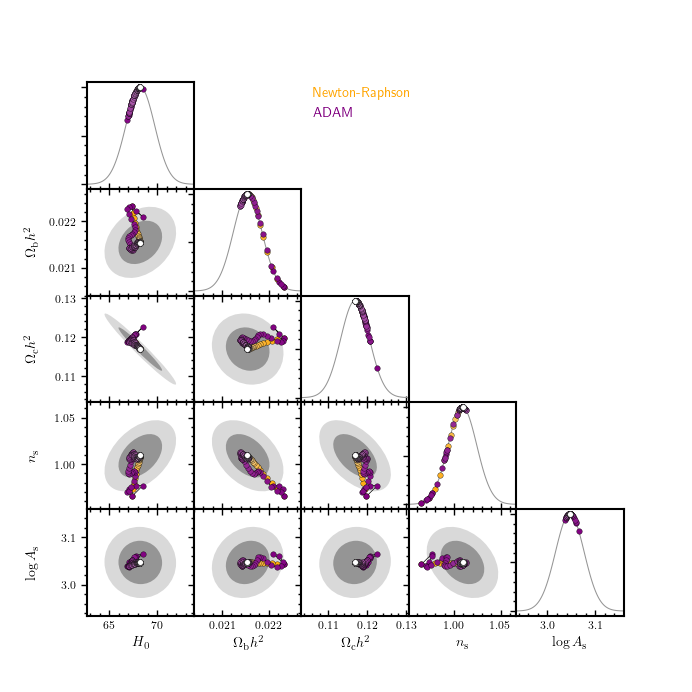

In [9]:
# Make a triangle plot and trace the journey of the two minimisers!
# You can see that while the two minimisers start at the same point they take very different journeys.
# ADAM's journey may seem erratic, but it tries to explore the parameter space more thoroughly to make sure
# it does not get stuck in a local minimum.

# Only plot cosmological parameters
pars_to_plot = ["H0", "ombh2", "omch2", "ns", "logA"]

plt.close()

# Plot parameters
sigma_plot_range = 3
sigma_levels = 2

ax = candl.plots.triangle_plot_from_cov(pars_to_plot = pars_to_plot,# which parameters to plot
                                        bf_point = newton_points[-1],# Newton best-fit point
                                        par_cov = newton_par_covs[-1],# the parameter covariance matrix
                                        pars_in_cov = pars_for_min,# the order of parameters in the covariance
                                        sigma_plot_range = sigma_plot_range,# sets the axes limits
                                        sigma_levels = sigma_levels)# how many sigma levels to plot

# Plot the Newton minimiser
candl.plots.add_min_trajectory(ax = ax,# axis instance
                               pars_to_plot = pars_to_plot,# which parameters to plot
                               eval_points = newton_points,# a list of all the points in the minimiser trajectory
                               par_cov = newton_par_covs[-1],# covariance of the best run - this is used to set the correct height in the 1d panels
                               pars_in_cov = pars_for_min,# the order of parameters in the covariance
                               bf_point = newton_points[-1],# the best-fit point - again used in the 1d panels
                               dark_colours=False,
                               base_colour = "orange")# the base colour used to show the trajectory path

# Plot the Adam minimiser
candl.plots.add_min_trajectory(ax = ax,# axis instance
                               pars_to_plot = pars_to_plot,# which parameters to plot
                               eval_points = adam_eval_points,# a list of all the points in the minimiser trajectory
                               par_cov = newton_par_covs[-1],# covariance of the best run - this is used to set the correct height in the 1d panels
                               pars_in_cov = pars_for_min,# the order of parameters in the covariance
                               bf_point = newton_points[-1],# the best-fit point - again used in the 1d panels
                               base_colour = "purple")# the base colour used to show the trajectory path

# Add a make-shift legend
ax[0,0].text(newton_points[-1][pars_to_plot[0]]+6*sigma_levels*np.sqrt(newton_par_covs[-1][0,0]),
             0.9,
             "Newton-Raphson",
             color="orange")
ax[0,0].text(newton_points[-1][pars_to_plot[0]]+6*sigma_levels*np.sqrt(newton_par_covs[-1][0,0]),
             0.7,
             "ADAM",
             color="purple")

plt.show()

# BlackJAX

Finally, we interface the likelihood with BlackJAX to run the NUTS sampler.
Again, a little set-up is needed as BlackJAX prefers to work with vectors rather than dictionaries.

In [10]:
# Wrap the likelihood in a function that takes in a vector of parameters (defined by pars_for_min)
@jax.jit
def like_normed_vec(input_vec):
    par_dict = {pars_for_min[i]: input_vec[i] for i in range(len(pars_for_min))}
    nenormed_par_dict = transform_from_zero_mean_unit_var(par_dict)
    return like(nenormed_par_dict)

# Define the inference loop
# This code is taken from the BlackJAX tutorial
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state
    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)
    return states

In [11]:
# Run NUTS chains! This takes about a minute.
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))# grab random number for starting point
nuts = blackjax.nuts(like_normed_vec, step_size=0.1, inverse_mass_matrix=np.ones(len(pars_for_min)))
initial_state = nuts.init(np.zeros(len(pars_for_min)))
states = inference_loop(rng_key,
                        nuts.step,
                        initial_state,
                        100)# Number of desired samples

In [12]:
# Restore units to samples and convert to a GetDist MCSamples object
fid_pars_vec = np.array([fid_pars[p] for p in pars_for_min])
def denorm_pars(pars):
    return pars*np.sqrt(np.diag(newton_par_covs[-1]))+fid_pars_vec
NUTS_samples = jnp.apply_along_axis(denorm_pars, 1, states.position)

gd_samples_NUTS = MCSamples(samples = np.array(NUTS_samples),
                            names = pars_for_min,
                            labels = [candl.plots.PAR_LABEL_DICT[p] if p in candl.plots.PAR_LABEL_DICT else p for p in pars_for_min],
                            label='BlackJAX NUTS')
gd_samples_NUTS.loglikes = np.zeros(100)# BlackJAX doesn't return logl values, we set these to zero here

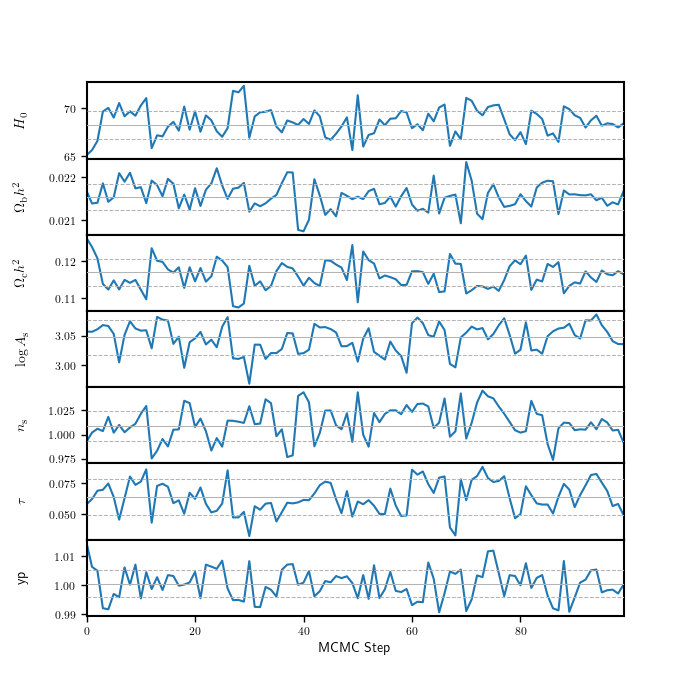

In [13]:
# Plot the NUTS samples!
# These are much less correlated than the MH samples from the traditional tutorial.
plt.close()
fig, ax = candl.plots.plot_mcmc_chain_steps(gd_samples_NUTS,# samples to plot
                                            list(fid_pars.keys()),# parameters to plot
                                            newton_points[-1],# best-fit point
                                            newton_par_covs[-1],# Fisher matrix from the Newton minimiser
                                            pars_for_min,# order of parameters in covariance matrix
                                            show_logl=False)# Order of paramters in the Fisher matrix
plt.show()